In [1]:
import numpy as np
import sys
import os
sys.path.append(os.path.join("./", "..", ".."))
np.random.seed(1)
run = False

In [2]:
# Configure the data generation process and train the autoencoder

def gen(n = 400):

    x = np.zeros((n, 4))

    for i in range(n):

        if np.random.uniform() < 0.5:
            x[i, 0] = 1.0 + np.random.normal(loc = 0.0, scale = 0.2)

        if np.random.uniform() < 0.5:
            x[i, 1] = 1.0 + np.random.normal(loc = 0.0, scale = 0.2)

        x[i, 2] = np.random.normal(loc = 0.0, scale = 0.5)

        x[i, 3] = x[i, 0] + np.random.normal(loc = 0.0, scale = 0.05)

    return x

if run:
    x = gen()
    np.save("./x.npy", x)
else:
    x = np.load("./x.npy")

In [3]:
from Model import *
model = Model.Initialize('autoencoder', x, pretrained_path='./../../Models/best.pt')

Loading the pretrained model...


In [4]:
from sklearn.cluster import KMeans
num_clusters = 4

rep = model.Encode(x)
kmeans = KMeans(n_clusters = num_clusters, random_state=100).fit(rep)

In [5]:
from eldr.plotter.myplot import *

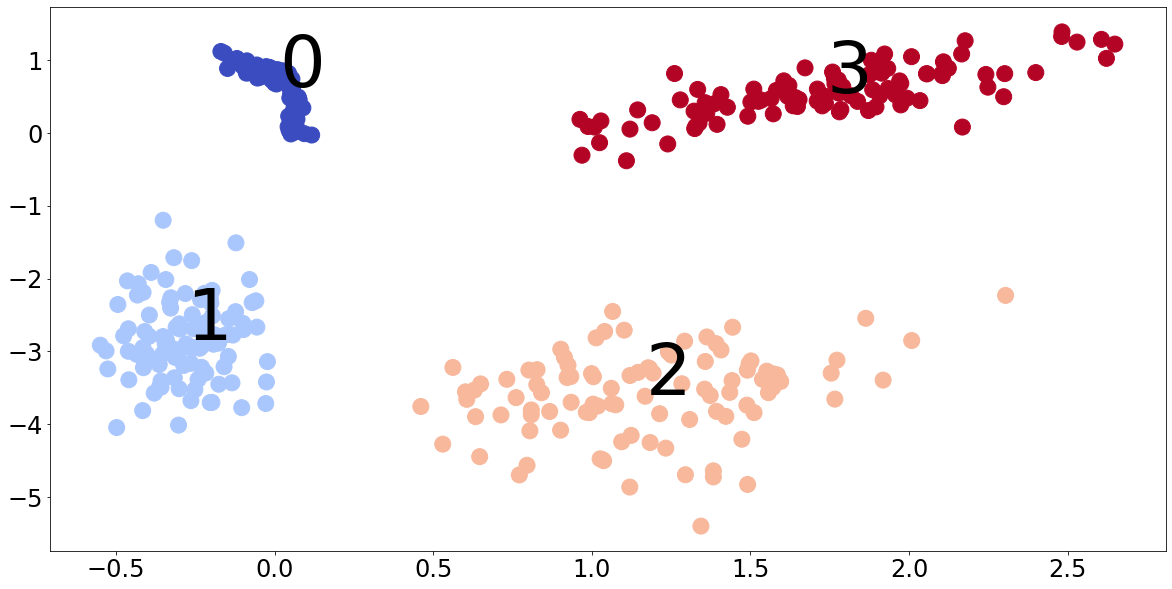

In [6]:
means, centers, indices = plot_groups(x, rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

In [7]:
from eldr.explain.explain_cs import *

In [8]:
#find the best_epsilon
from eldr.explain.explain_cs import *
epsilon = 0

Explainer = Explain(model, means, centers, use_scaling=False)

epsilons = np.linspace(0, 2.0, num=100).tolist()
for iter_epsilon in epsilons:
    mean_, min_, max_ = Explainer.eval_epsilon(torch.tensor(x), indices, iter_epsilon)
    if mean_ >= 0.95 and min_ >= 0.95 and max_>= 0.95:
        epsilon = iter_epsilon
        break
print(epsilon)

0.2828282828282829


In [9]:
import os
import json
from types import SimpleNamespace
best_val = 0.0
ntrials = 10
lg = 1.5
config = SimpleNamespace(**json.load(open('./../../configs/tgt.json', 'r')))
# for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
if run:
    for i in range(ntrials):
        print("Trial: ", i)
        config.lambda_global = lg
        Explainer = Explain(model, means, centers)
        deltas, tgt = Explainer.explain(config)
        a, b = Explainer.metrics(torch.tensor(x), indices, deltas, epsilon)

        val = np.mean(a)

        if val > best_val:
            best_val = val
            print("best_val ", best_val, "deltas ", deltas)
            np.save("deltas.npy", deltas)

        os.system("rm -rf explanation")

In [10]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
deltas = np.load("deltas.npy")
print(deltas)

[[1.014886 0.004554 0.004127 0.868280]
 [1.018155 1.006689 0.004222 0.874072]
 [-0.000136 0.903550 -0.002607 -0.003352]]


./../../eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home/jim/anaconda3/envs/factai/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


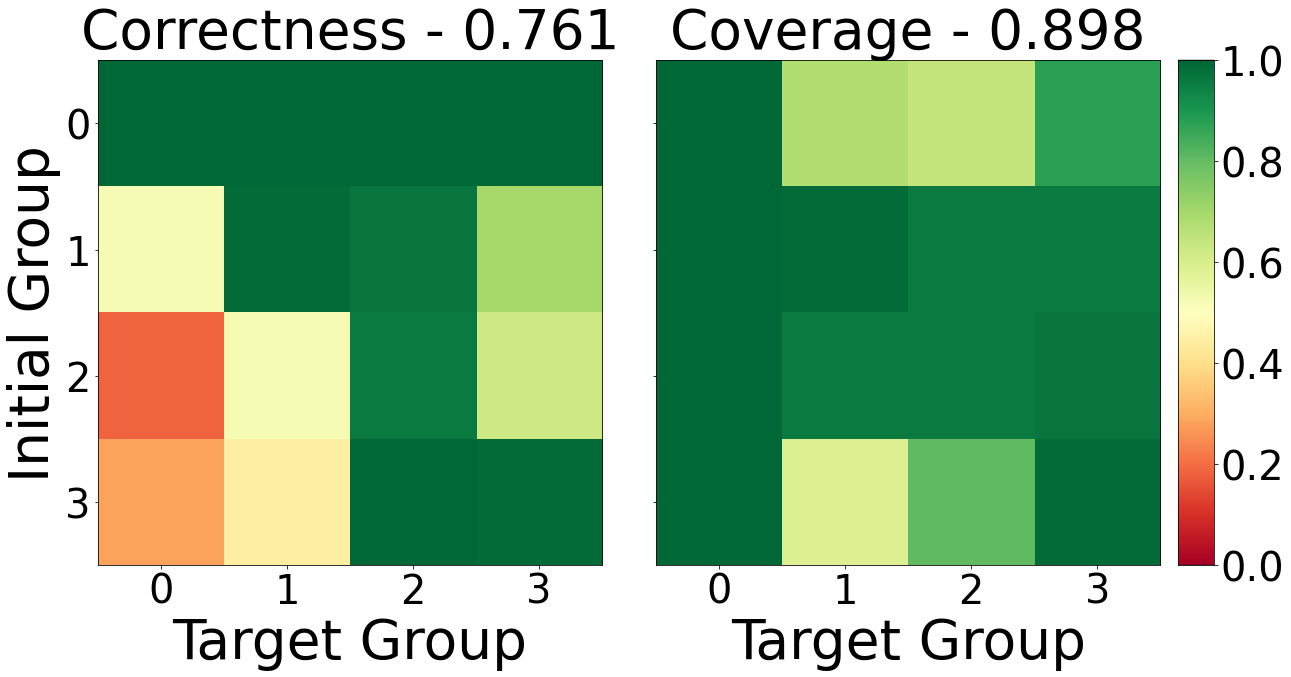

In [11]:
# Evaluate the explanations
deltas = np.load("deltas.npy")

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas), epsilon)

plot_metrics(a, b, name = "synth-metrics-ours.png")

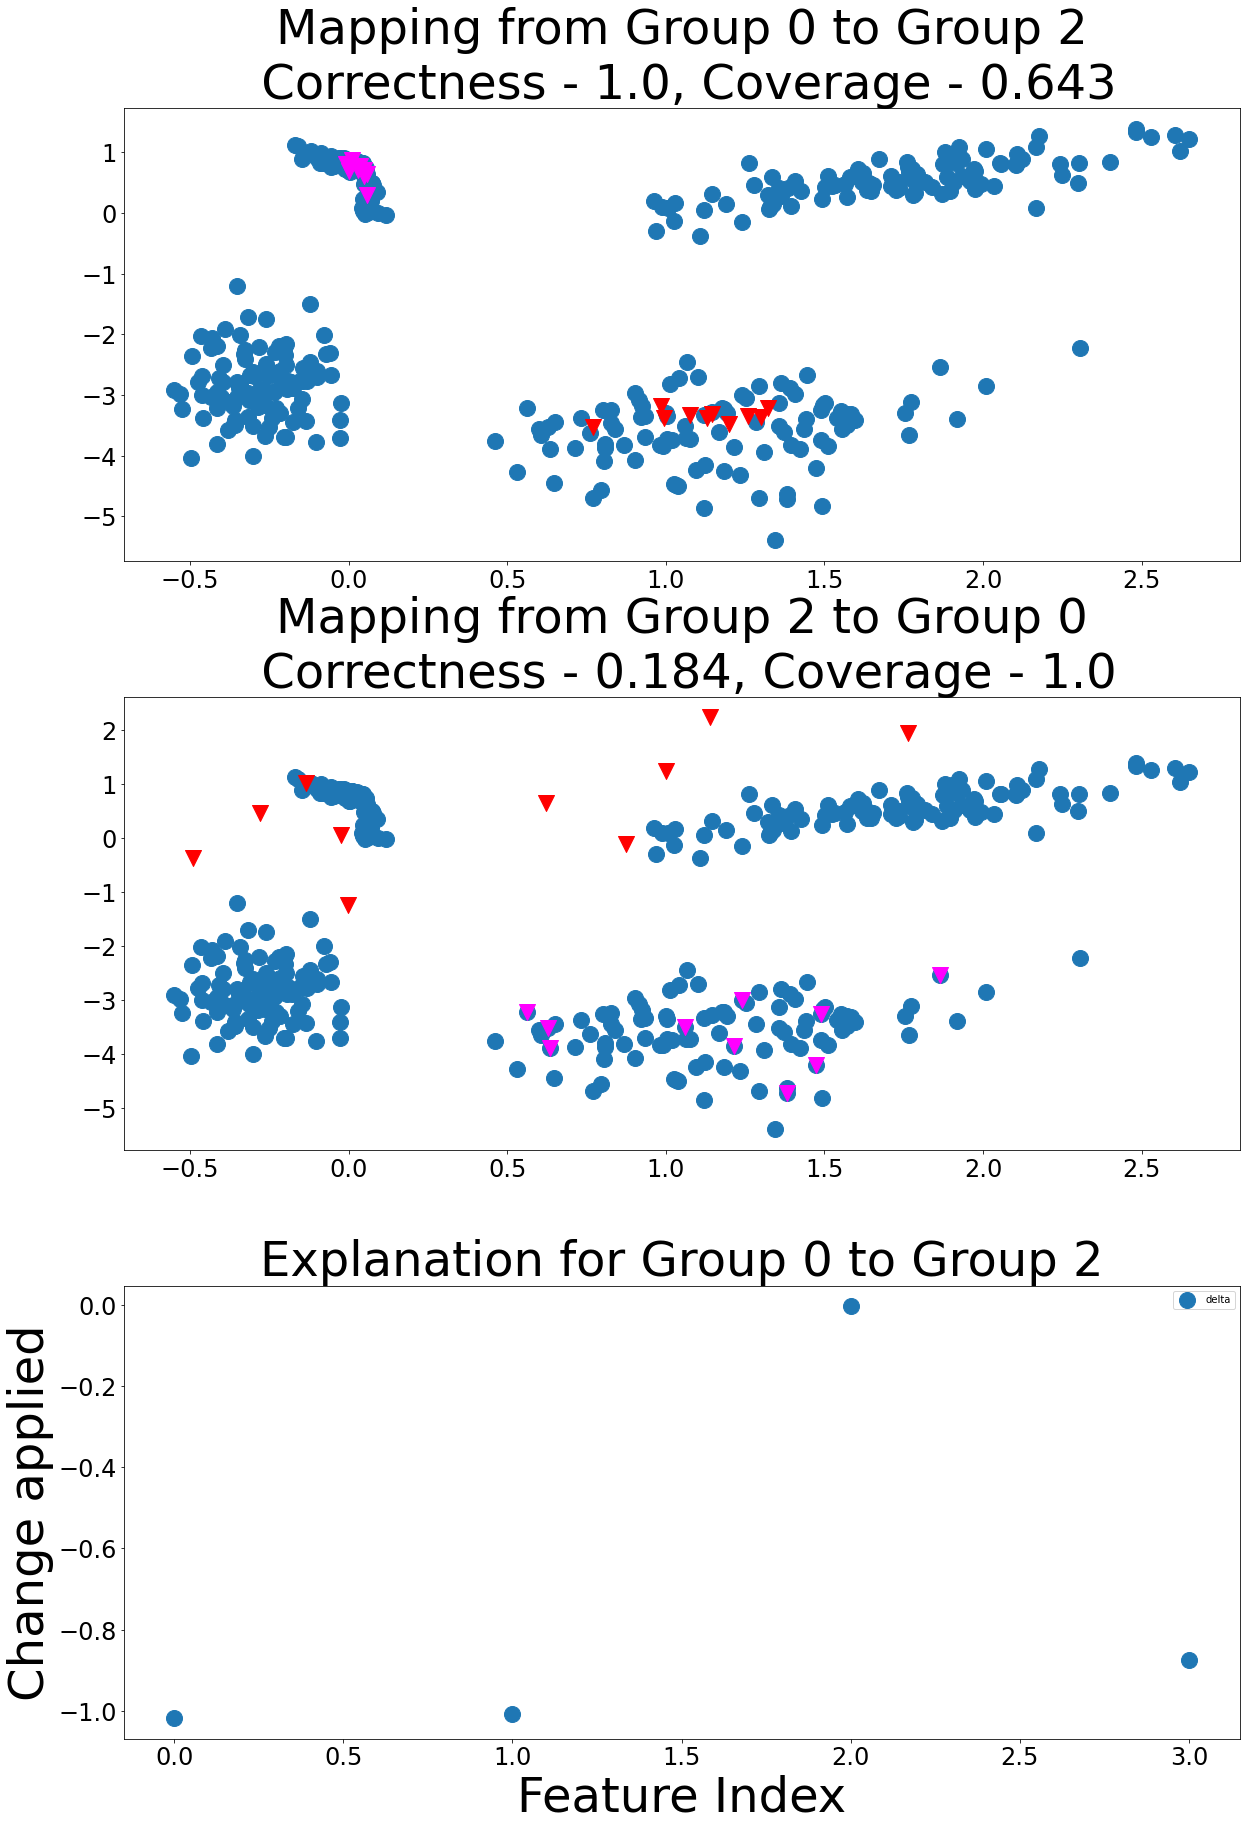

In [12]:
plot_explanation(model, x, rep, indices, deltas, a, b, 0, 2, num_points = 10, name = "tst_synthetic.png")

### Experiments with Scaling ON

In [13]:
import os
import json
from types import SimpleNamespace
best_val = 0.0
ntrials = 10
# lg = 1.5
config = SimpleNamespace(**json.load(open('./../../configs/tgt.json', 'r')))
if run:
    for i in range(ntrials):
        print("Trial: ", i)
        config.lambda_global = lg
        Explainer = Explain(model, means, centers, use_scaling=True)
        deltas_with_scaling, gamma, tgt = Explainer.explain(config)
        a, b = Explainer.metrics(torch.tensor(x), indices, deltas_with_scaling, epsilon, logit_gammas=gamma)

        val = np.mean(a)
        print(val)

        if val > best_val:
            best_val = val
            print("lambda_global: ", lg, "trial ", i)
            print("best_val ", best_val, "deltas ", deltas_with_scaling, "gamma ", gamma)
            np.save("deltas_with_scaling.npy", deltas_with_scaling)
            np.save("gamma.npy", gamma)

        os.system("rm -rf explanation")

In [14]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
deltas = np.load("deltas_with_scaling.npy")
gamma = np.load("gamma.npy")
print(deltas)
print(gamma)


[[1.013577 0.000712 -0.002737 0.882920]
 [1.015738 1.020012 -0.002821 0.873159]
 [-0.004091 0.951670 -0.004036 0.000093]]
[[-0.002083 -0.002210 0.002433 0.002211]
 [0.002292 0.086320 0.002242 0.003686]
 [-0.000393 0.087989 0.000797 0.000282]]


./../../eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)


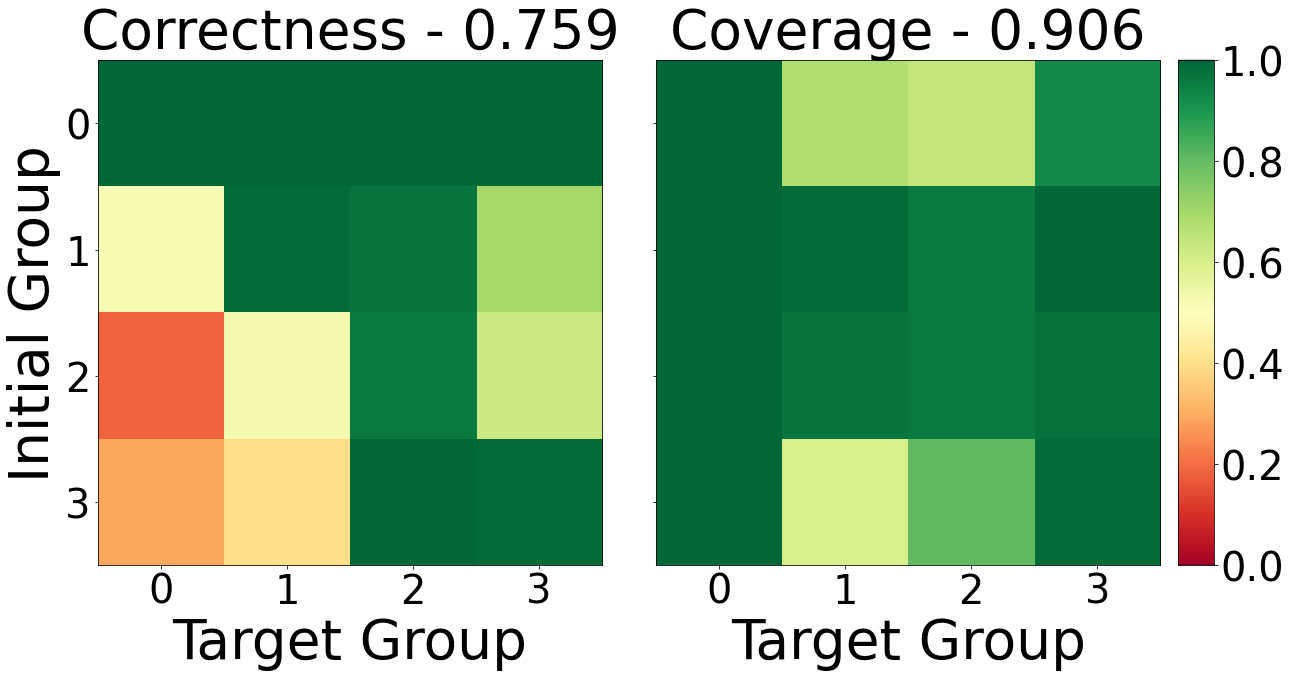

In [15]:
# Evaluate the explanations
deltas = np.load("deltas_with_scaling.npy")
gamma = np.load("gamma.npy")
a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas), epsilon, logit_gammas=torch.from_numpy(gamma))

plot_metrics(a, b, name = "synth-metrics-scaling.png")

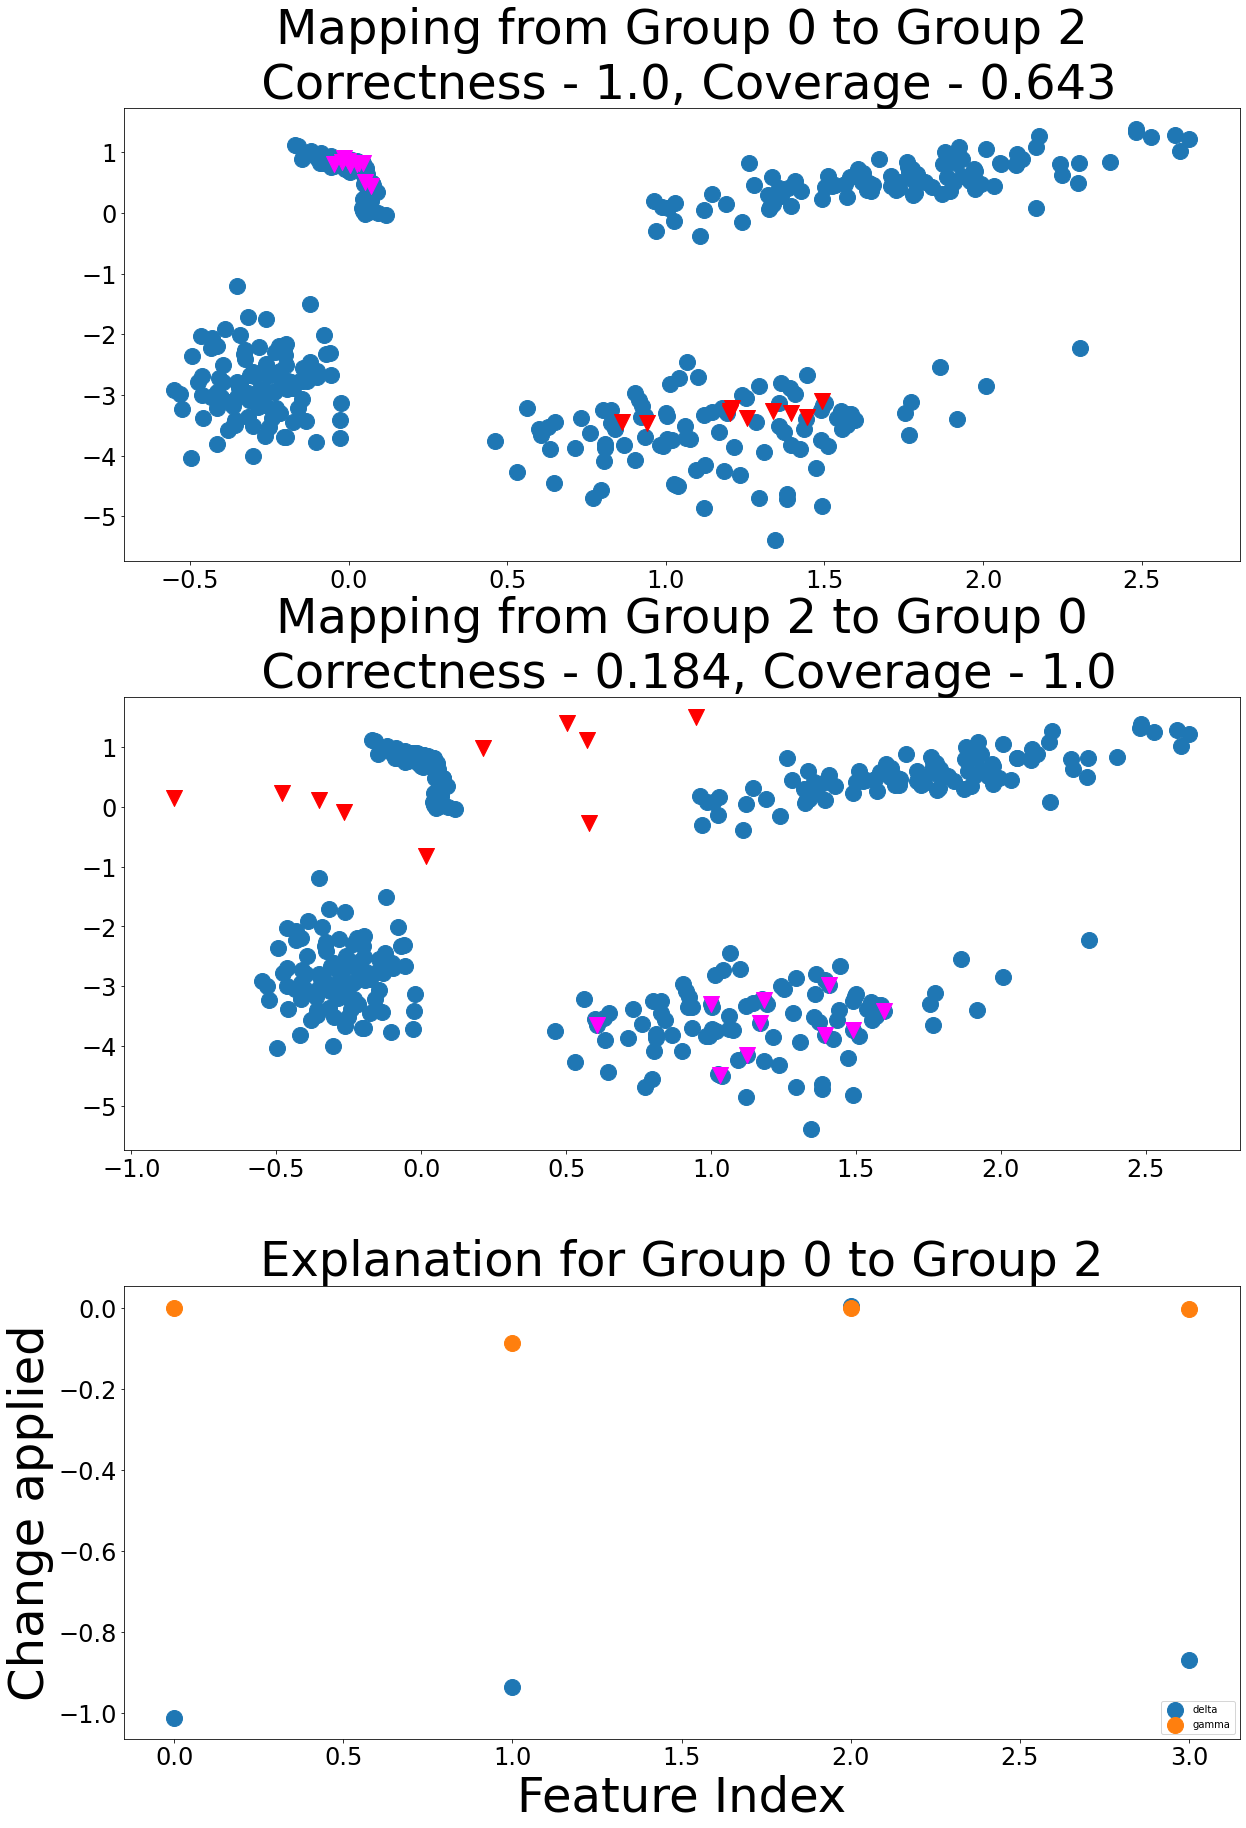

In [16]:
plot_explanation(model, x, rep, indices, deltas, a, b, 0, 2, num_points = 10, name = "tst_synthetic_scaling.png", logit_gammas=torch.from_numpy(gamma))

### Experiment on Modified Synthetic Dataset

In [17]:
# means, centers, indices

In [18]:
# gp_1 = indices[1]

In [19]:
# rep_1 = rep[gp_1]
# x_1 = x[gp_1]
# x_1

In [20]:
# a = np.random.uniform(1.0, 2.0)
# b = np.random.uniform(-0.5, 1.0)
# a, b

In [21]:
a, b = 1.9989851743919034, 0.6045677338202162

In [22]:
# x_1[:, 0] = a*x_1[:,0] + b
# x_1

In [23]:
# x_modified = np.zeros(x.shape)

# modified_cluster = 1

# for j in range(num_clusters):
#     if j == modified_cluster:
#         for i, ind in enumerate(indices[j]):
#             x_modified[ind, :] = x_1[i]
#     else:
#         for i, ind in enumerate(indices[j]):
#             x_modified[ind, :] = x[indices[j]][i]

            
x_modified = np.load("./x_modified.npy")

In [24]:
rep_modified = model.Encode(x_modified)

In [25]:
from sklearn.cluster import KMeans
num_clusters = 4


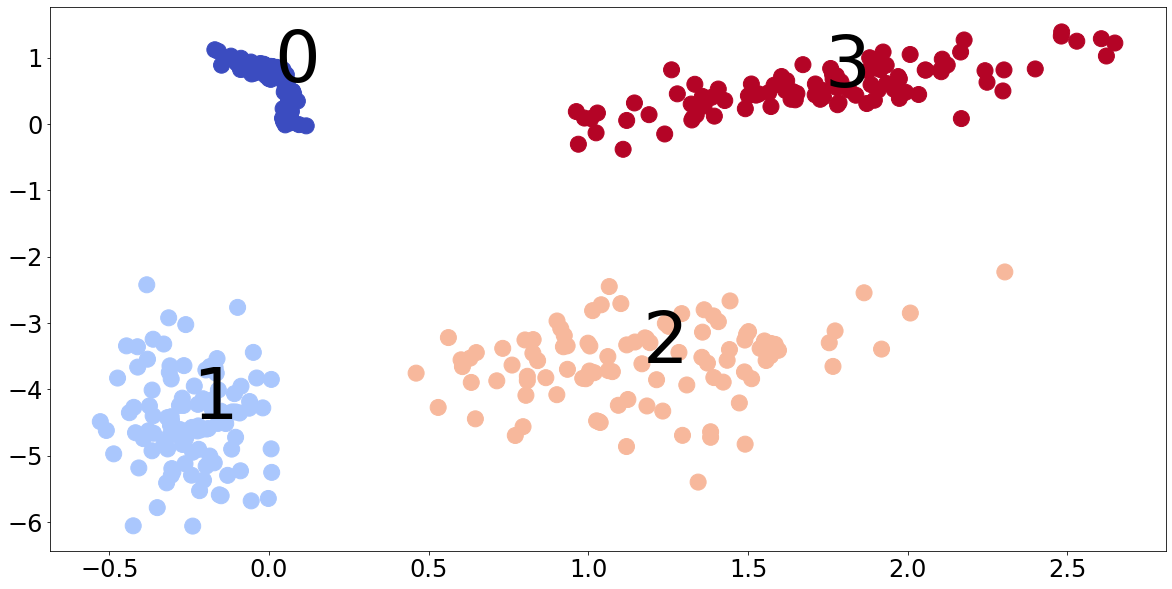

In [26]:
means_modified, centers_modified, indices_modified = plot_groups(x_modified, rep_modified.numpy(), num_clusters, kmeans.labels_, name = "./modified.png")

In [27]:
#find the best_epsilon
from eldr.explain.explain_cs import *
epsilon = 0

Explainer = Explain(model, means, centers, use_scaling=False)

epsilons = np.linspace(0, 2.0, num=100).tolist()
for iter_epsilon in epsilons:
    mean_, min_, max_ = Explainer.eval_epsilon(torch.tensor(x), indices, iter_epsilon)
    if mean_ >= 0.95 and min_ >= 0.95 and max_>= 0.95:
        epsilon = iter_epsilon
        break
print(epsilon)

0.2828282828282829


##### Get Deltas with regular TGT

In [28]:
import os
import json
from types import SimpleNamespace
best_val = 0.0
ntrials = 10
lg = 1.5
config = SimpleNamespace(**json.load(open('./../../configs/tgt.json', 'r')))
if run:
    for i in range(ntrials):
        print("Trial: ", i)
        config.lambda_global = lg
        Explainer = Explain(model, means_modified, centers_modified)
        deltas, tgt = Explainer.explain(config)
        a, b = Explainer.metrics(torch.tensor(x_modified), indices_modified, deltas, epsilon)

        val = np.mean(a)

        if val > best_val:
            best_val = val
            print("best_val ", best_val, "deltas ", deltas)
            np.save("deltas_modified.npy", deltas)

        os.system("rm -rf explanation")

./../../eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)


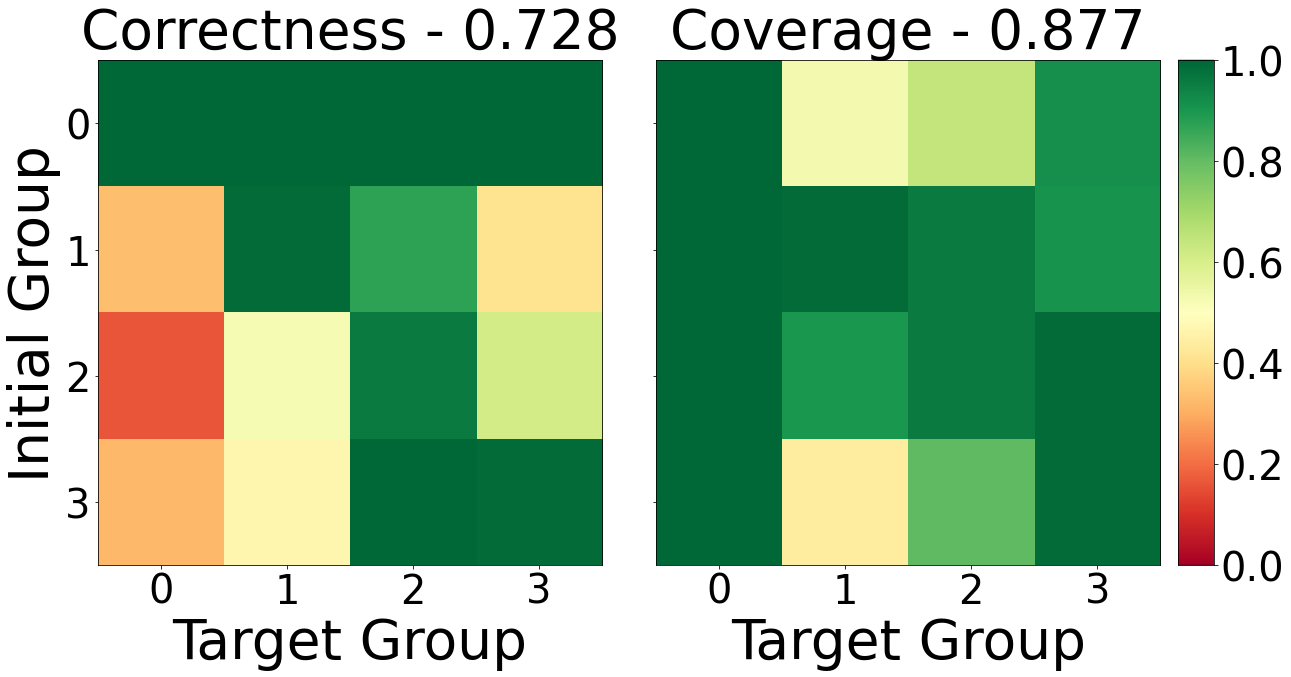

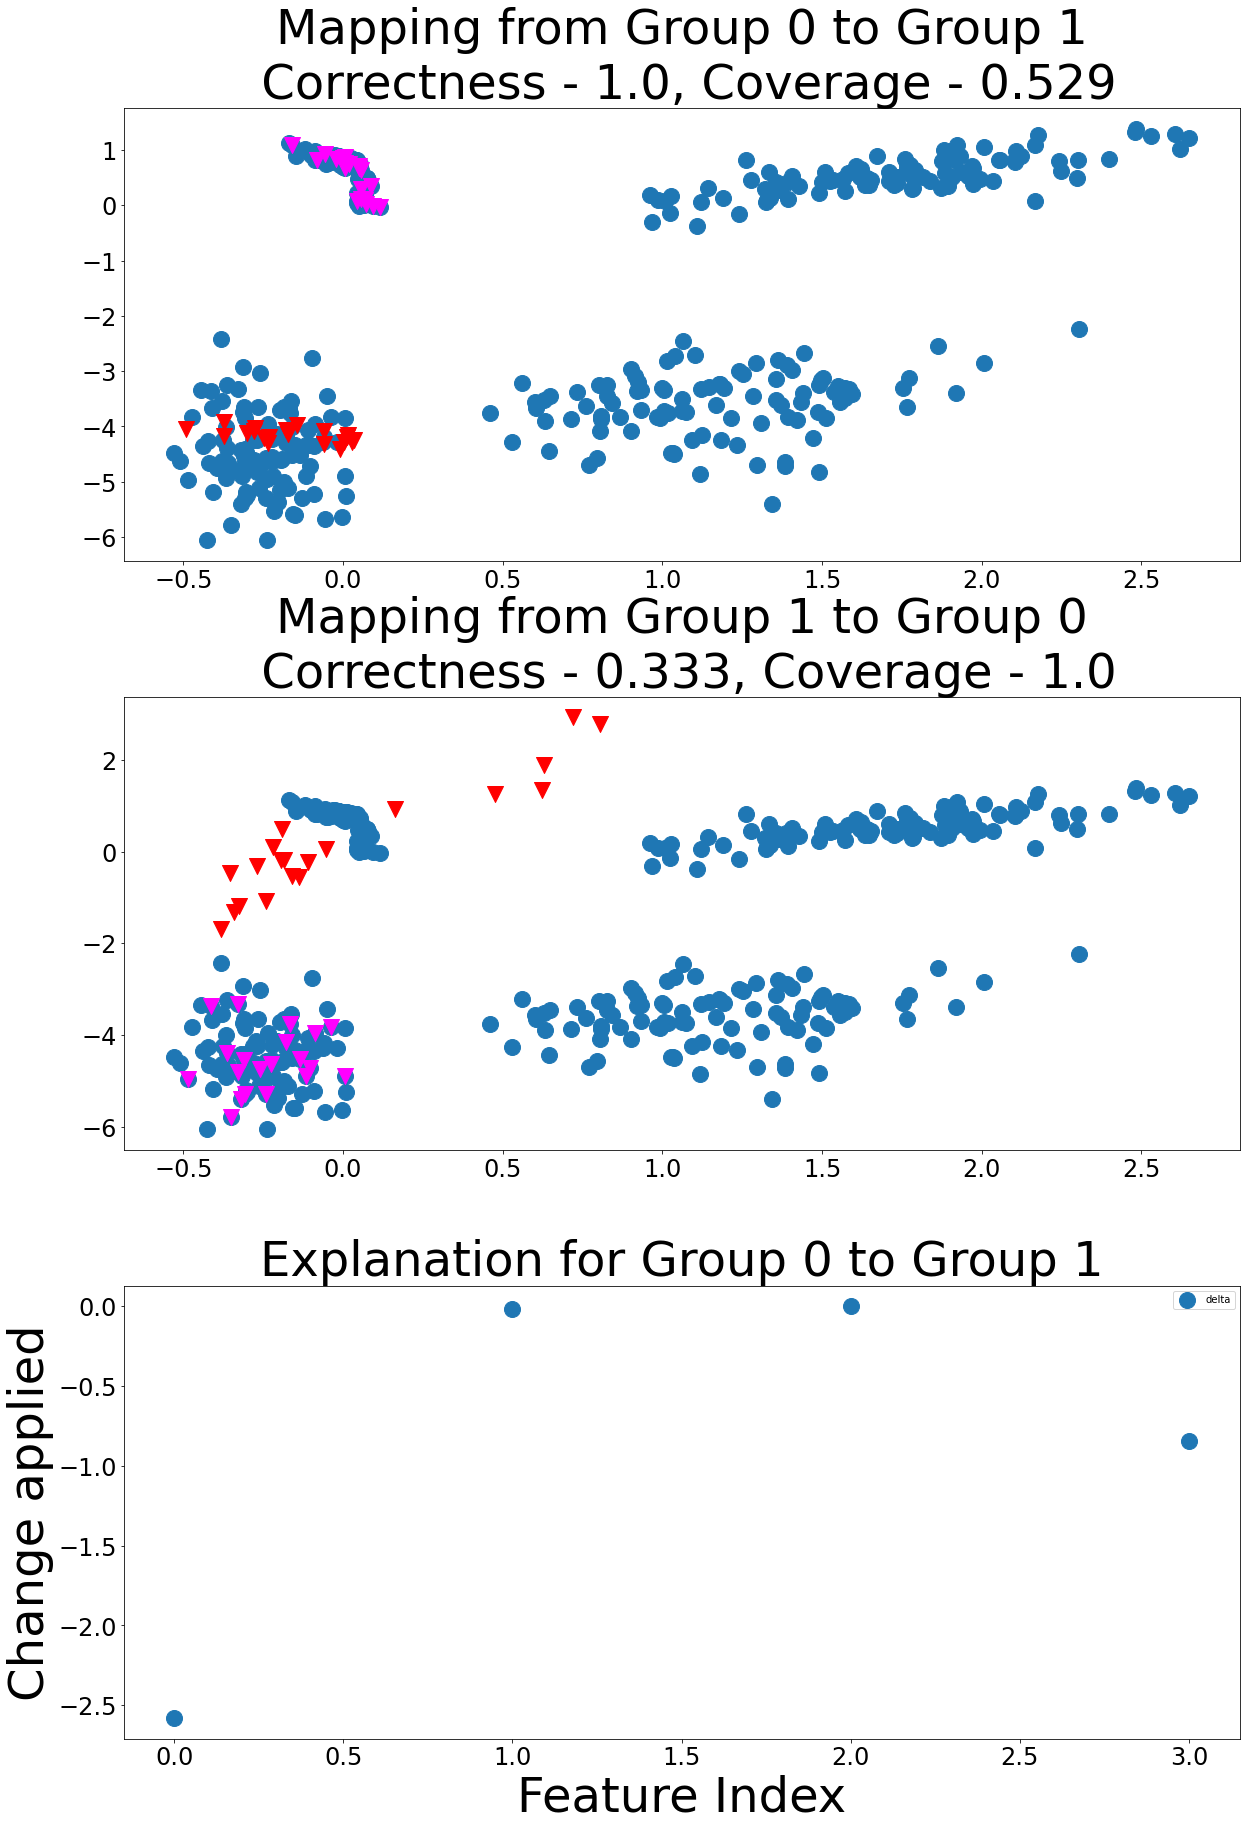

In [29]:
deltas = np.load("./deltas_modified.npy")
a, b = Explainer.metrics(torch.tensor(x_modified), indices_modified, deltas, epsilon)
plot_metrics(a, b, name = "synth-metrics_modified.png")
plot_explanation(model, x_modified, rep_modified, indices_modified, deltas, a, b, 0, 1, num_points = 20, name = "synthetic_modified.png")

##### TGT with Scaling

In [30]:
import os
import json
from types import SimpleNamespace
best_val = 0.0
ntrials = 10
# lg = 1.5
config = SimpleNamespace(**json.load(open('./../../configs/tgt.json', 'r')))
if run:
    for i in range(ntrials):
        print("Trial: ", i)
        config.lambda_global = lg
        Explainer = Explain(model, means_modified, centers_modified, use_scaling=True)
        deltas_with_scaling, gamma, tgt = Explainer.explain(config)
        a, b = Explainer.metrics(torch.tensor(x_modified), indices_modified, deltas_with_scaling, epsilon, logit_gammas=gamma)

        val = np.mean(a)
        print(val)

        if val > best_val:
            best_val = val
            print("lambda_global: ", lg, "trial ", i)
            print("best_val ", best_val, "deltas ", deltas_with_scaling, "gamma ", gamma)
            np.save("deltas_with_scaling1_modified.npy", deltas_with_scaling)
            np.save("gamma_modified.npy", gamma)

        os.system("rm -rf explanation")

./../../eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)


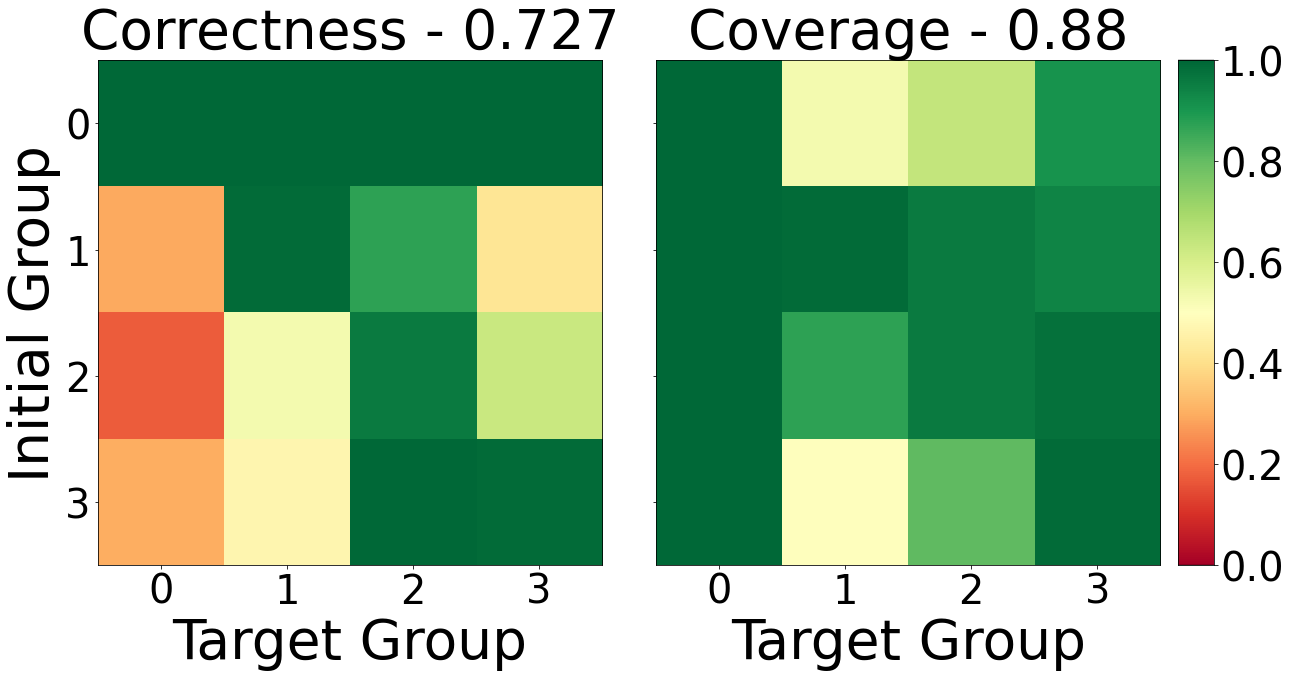

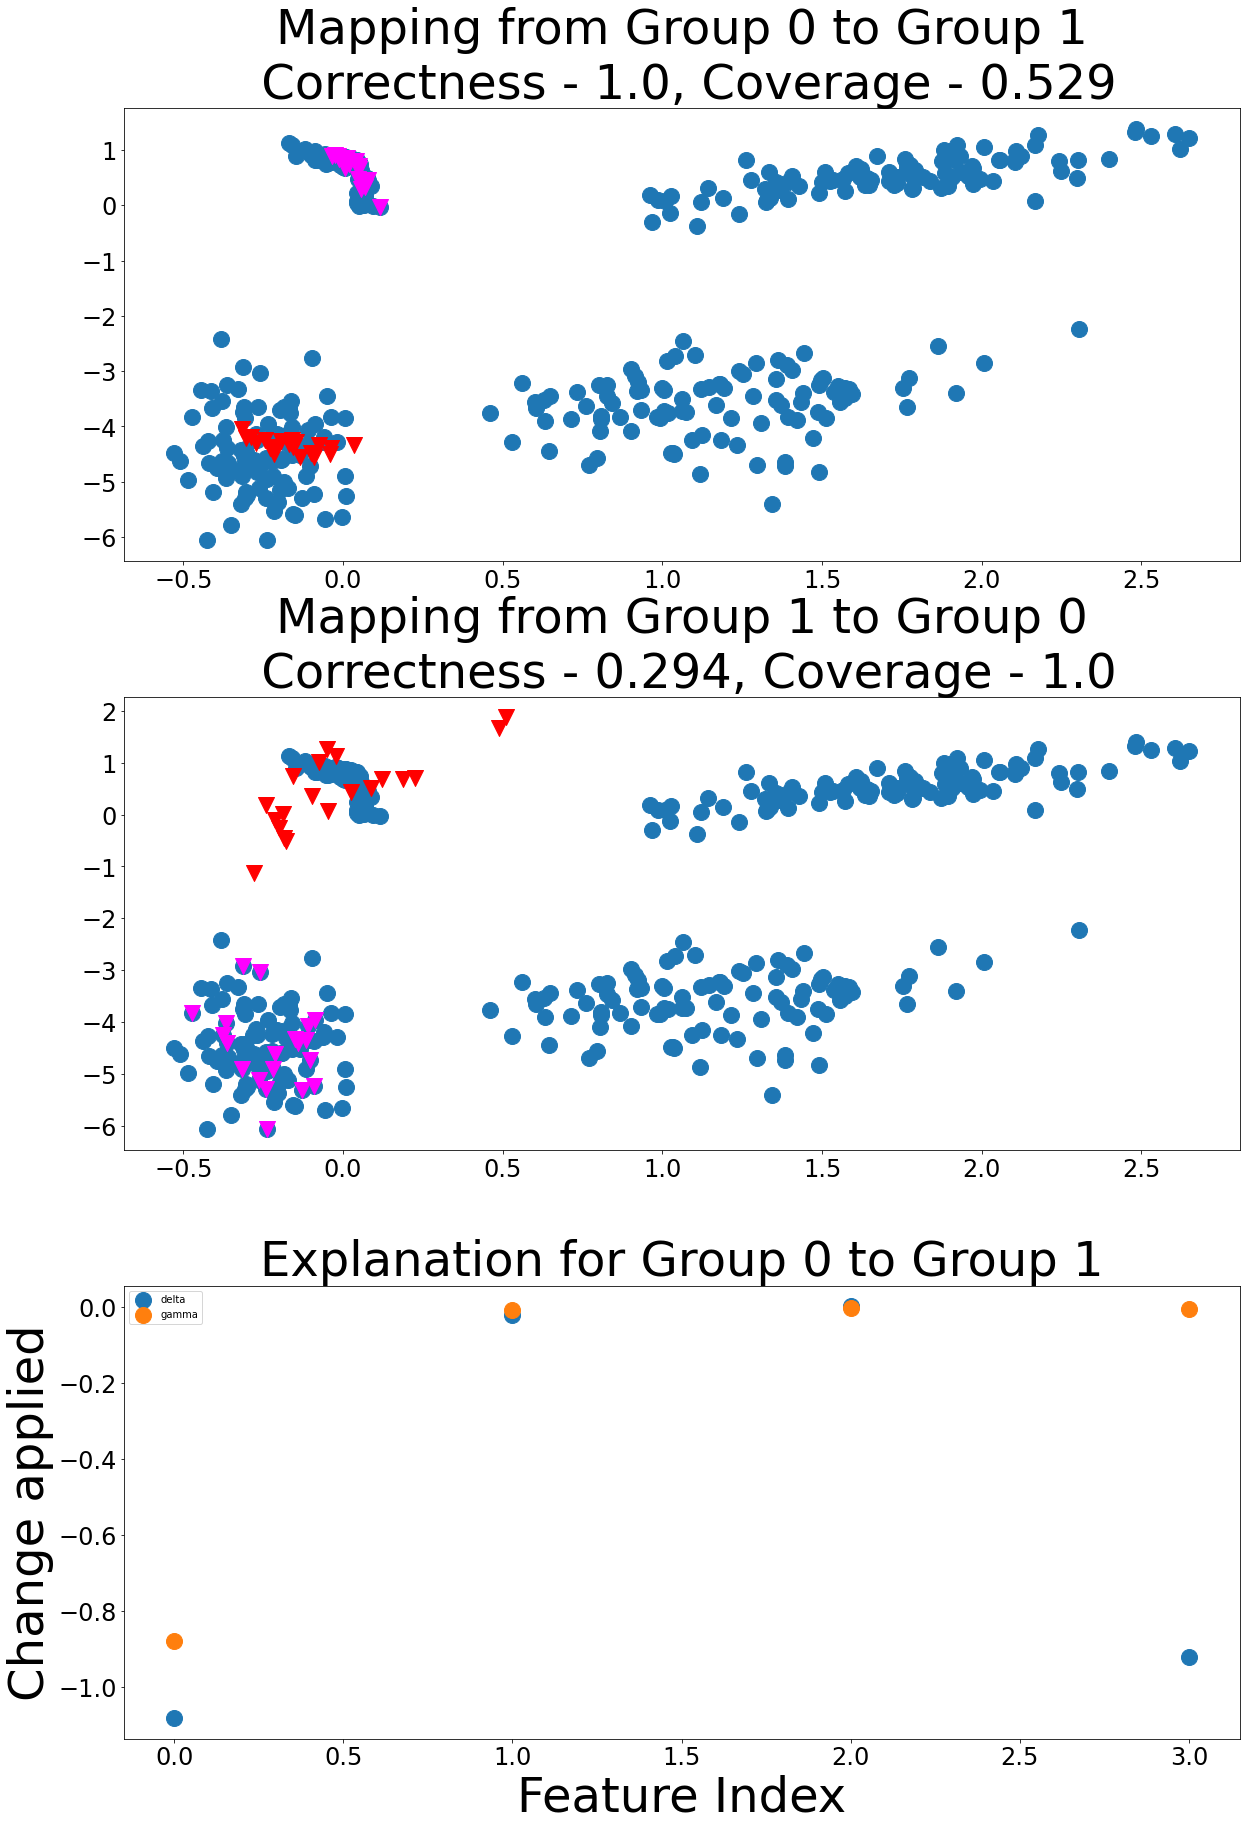

In [31]:
deltas_with_scaling = np.load("./deltas_with_scaling1_modified.npy")
gamma = np.load("./gamma_modified.npy")
a, b = Explainer.metrics(torch.tensor(x_modified), indices_modified, deltas_with_scaling, epsilon, logit_gammas=torch.from_numpy(gamma))

plot_metrics(a, b, name = "synth-metrics-scaling_modified.png")
plot_explanation(model, x_modified, rep_modified, indices_modified, deltas_with_scaling, a, b, 0, 1, num_points = 20, name = "synthetic_modified_scaling.png", logit_gammas=torch.from_numpy(gamma))

In [32]:
deltas, deltas_with_scaling

(array([[2.580799, 0.014373, 0.001137, 0.841995],
        [1.036298, 1.009043, 0.004162, 0.827394],
        [0.001783, 0.958711, -0.001713, 0.001886]], dtype=float32),
 array([[2.607932, 0.022620, -0.001362, 0.926833],
        [1.027585, 1.020110, -0.004272, 0.868336],
        [-0.007820, 0.938316, -0.001145, 0.004923]], dtype=float32))

In [33]:
gamma

array([[0.879107, 0.008635, 0.001983, 0.006824],
       [0.234019, 0.083807, 0.002810, -0.000243],
       [0.001311, 0.078478, 0.003451, 0.000722]], dtype=float32)

In [34]:
# np.save('x.npy', x)
# np.save('x_modified.npy', x_modified)
# import pickle
# pickle.dump(kmeans, open("kmeans.pkl", "wb"))

In [35]:
# x = np.load('x.npy')
# rep = model.Encode(x)
# kmeans_ = KMeans(n_clusters = num_clusters, random_state=100).fit(rep)

In [36]:
# means, centers, indices = plot_groups(x, rep.numpy(), num_clusters, kmeans_.labels_, name = "tst.png")